In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [2]:
maxlen = 1000

training_samples = 15000
validation_sample = 6000

max_words = 10000

In [3]:
dataset = pd.read_csv('../Data/train.csv')

# data

In [20]:
nan_idx = dataset[pd.isnull(dataset.text)].index.tolist()
dataset.loc[nan_idx, 'text'] = ' '

text = dataset.text.tolist()
labels = dataset.label.tolist()

In [5]:

tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

word_index = tokenizer.word_index
print(f'Znaleziono {len(word_index)} unikatowych tokenów.')

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)

print(f'Kształt tensora danych: {data.shape}')
print(f'Kształt tensora etykiet: {labels.shape}')

Znaleziono 238051 unikatowych tokenów.
Kształt tensora danych: (20800, 1000)
Kształt tensora etykiet: (20800,)


In [6]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_sample]
y_val = labels[training_samples: training_samples + validation_sample]

In [7]:
load_glove = True

In [9]:
if load_glove:
    embedding_index = {}
    with open('glove/glove.6B.100d.txt', encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs

    embedding_dim = 100

    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if i < max_words:
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    print('Glove załadowane!')

Glove załadowane!


In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
if load_glove:
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(Flatten())
else:
    model.add(Dense(32, activation='relu', input_shape=(maxlen,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

if load_glove:
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                3200032   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,200,065
Trainable params: 4,200,065
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',])
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

model.save_weights('pre_trained_model.h5')

Epoch 1/20
30/30 [==============================] - 5s 162ms/step - loss: 1.9166 - acc: 0.6070 - val_loss: 0.6059 - val_acc: 0.6993
Epoch 2/20
30/30 [==============================] - 5s 157ms/step - loss: 0.6140 - acc: 0.6657 - val_loss: 0.5736 - val_acc: 0.6921
Epoch 3/20
30/30 [==============================] - 5s 156ms/step - loss: 0.5844 - acc: 0.6867 - val_loss: 0.5933 - val_acc: 0.6762
Epoch 4/20
30/30 [==============================] - 5s 157ms/step - loss: 0.6023 - acc: 0.6797 - val_loss: 0.5988 - val_acc: 0.6745
Epoch 5/20
30/30 [==============================] - 5s 156ms/step - loss: 0.5693 - acc: 0.7131 - val_loss: 0.5764 - val_acc: 0.7131
Epoch 6/20
30/30 [==============================] - 5s 157ms/step - loss: 0.5517 - acc: 0.7230 - val_loss: 0.7439 - val_acc: 0.6602
Epoch 7/20
30/30 [==============================] - 5s 157ms/step - loss: 0.5393 - acc: 0.7494 - val_loss: 0.5484 - val_acc: 0.7809
Epoch 8/20
30/30 [==============================] - 5s 157ms/step - loss: 0.

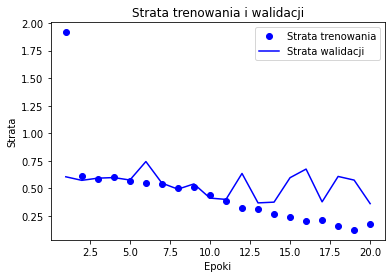

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')

plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

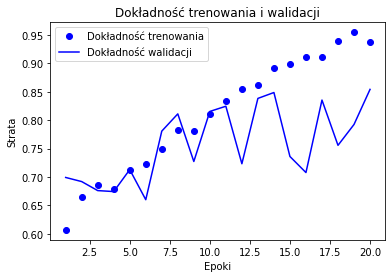

In [14]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Dokładność trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokładność walidacji')

plt.title('Dokładność trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

In [15]:
print('Uczenie zakończone!')

Uczenie zakończone!


In [23]:
test_dataset = pd.read_csv('../Data/test.csv')
labels_dataset = pd.read_csv('../Data/submit.csv')

nan_idx = test_dataset[pd.isnull(test_dataset.text)].index.tolist()
test_dataset.loc[nan_idx, 'text'] = ' '
test_text = test_dataset.text.tolist()

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(test_text)
sequences = tokenizer.texts_to_sequences(test_text)

x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels_dataset.label.tolist())

model.load_weights('pre_trained_model.h5')
model.evaluate(x_test, y_test)

163/163 [==============================] - 2s 13ms/step - loss: 0.4114 - acc: 0.8263


[0.4113517999649048, 0.8263461589813232]

In [24]:
model.metrics_names

['loss', 'acc']